# MC Dropout
Following [this](https://arxiv.org/pdf/1506.02142.pdf) paper to implement MC dropout to get uncertainty from deep NNs using Tensorflow and MNIST.

In [39]:
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


from tqdm import tqdm

plt.style.use('ggplot')
sess = tf.InteractiveSession()

In [77]:
mnist = input_data.read_data_sets('MNIST_data/')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [78]:
X_train = mnist.train.images
y = mnist.train.labels

In [4]:
X_train, X_test, y, y_test = train_test_split(
     X_train, y, test_size=0.995, random_state=42, stratify=y)

In [79]:
X_train.shape

(55000, 784)

In [80]:
X_test = mnist.test.images
y_test = mnist.test.labels

In [81]:
N = X_train.shape[0]

#Possible output labels
K = 10
#Batch size
M = 128
#Size of hidden units
H= 1024
#Number of initial convolution features
U= 32
#Dimension of input to FC layer
D = 7*7*(U*2)

In [82]:
def generator(arrays, batch_size):
  """Generate batches, one with respect to each array's first axis."""
  starts = [0] * len(arrays)  # pointers to where we are in iteration
  while True:
    batches = []
    for i, array in enumerate(arrays):
      start = starts[i]
      stop = start + batch_size
      diff = stop - array.shape[0]
      if diff <= 0:
        batch = array[start:stop]
        starts[i] += batch_size
      else:
        batch = np.concatenate((array[start:], array[:diff]))
        starts[i] = diff
      batches.append(batch)
    yield batches
data = generator([X_train, y], M)

## Model

In [83]:
#Placeholders
x_p = tf.placeholder(tf.float32, shape=[None, 784])
y_p = tf.placeholder(tf.int64, shape=[None])
keep_prob = tf.placeholder(tf.float32)
keep_probc = tf.placeholder(tf.float32)

In [84]:
def weight(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [85]:
#Model parameters
Wconv1 = weight([5, 5, 1, U])
bconv1 = bias([U])
Wconv2 = weight([5, 5, U, U*2])
bconv2 = bias([U*2])

W0 = weight([D, H])
b0 = bias([H])
W1 = weight([H, K])
b1 = bias([K])

#Model
x = tf.reshape(x_p, [-1,28,28,1])
x = tf.nn.dropout(x, keep_probc)

x = tf.nn.relu(conv2d(x, Wconv1) + bconv1)
#x = tf.nn.dropout(x, keep_probc)

x = max_pool_2x2(x)
x = tf.nn.dropout(x, keep_probc)

x = tf.nn.relu(conv2d(x, Wconv2) + bconv2)
#x = tf.nn.dropout(x, keep_probc)

x = max_pool_2x2(x)
x = tf.nn.dropout(x, keep_probc)

x = tf.reshape(x, [-1, D])
x = tf.nn.relu(tf.matmul(x, W0) + b0)
x = tf.nn.dropout(x, keep_prob)

output = tf.nn.softmax(tf.matmul(x, W1) + b1)

cross_entropy =-tf.reduce_sum(tf.one_hot(y_p, 10)*tf.log(output))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(output,1), y_p)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

In [104]:
n_batch = int(N / M)
n_epoch = 5*10
iters = n_batch*n_epoch
dropout = 0.5
dropoutc = 0.8

In [105]:
for i in range(iters):
  X_batch, y_batch = next(data)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x_p:X_batch, y_p: y_batch, keep_prob: dropout, keep_probc:dropoutc})
    print("step %d, training accuracy %g"%(i, train_accuracy), end="\r", flush=True)
  train_step.run(feed_dict={x_p: X_batch, y_p: y_batch, keep_prob: dropout, keep_probc:dropoutc})

## Evaluation

In [93]:
#Out of distribution data for evaluating uncertainty estimation quality
nmnist = input_data.read_data_sets("notMNIST_data/")
X_test = nmnist.test.images
y_test = nmnist.test.labels

Extracting notMNIST_data/train-images-idx3-ubyte.gz
Extracting notMNIST_data/train-labels-idx1-ubyte.gz
Extracting notMNIST_data/t10k-images-idx3-ubyte.gz
Extracting notMNIST_data/t10k-labels-idx1-ubyte.gz


In [94]:
#Accuracy without MC dropout
feed_dict = feed_dict={
    x_p: X_test, keep_prob: dropout, keep_probc:dropoutc}
pred =output.eval(feed_dict)
y_pred = np.argmax(pred,axis=1)
print(" Accuracy on test set= ", (y_pred == y_test).mean()*100)

 Accuracy on test set=  16.16


In [95]:
n_samples = 50
pred_lst = []
feed_dict = feed_dict={
    x_p: X_test, keep_prob: dropout, keep_probc:dropoutc}
for _ in tqdm(range(n_samples)):
    pred =output.eval(feed_dict)
    pred_lst.append(pred)

100%|██████████| 50/50 [00:04<00:00, 11.02it/s]


In [96]:
preds = np.argmax(np.array(pred_lst),axis=2)

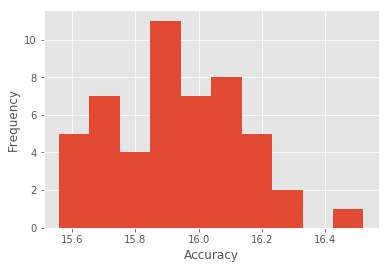

In [97]:
accy_test = []
for i in range(n_samples):
    y_trn_prd = preds[i,:]
    acc = (y_trn_prd == y_test).mean()*100
    accy_test.append(acc)
plt.hist(accy_test)
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.show()

In [98]:
#Model Averaging
y_pred = np.argmax(np.mean(pred_lst,axis=0),axis=1)
print(" Accuracy on test set= ", (y_pred == y_test).mean()*100)

 Accuracy on test set=  17.61


truth =  1


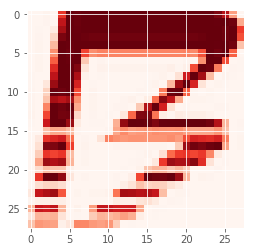

In [99]:
test_ind = 1178

test_image = X_test[test_ind]
test_label = y_test[test_ind]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels, cmap='Reds');

(array([  0.,   0.,   0.,   4.,   0.,   0.,  46.,   0.,   0.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

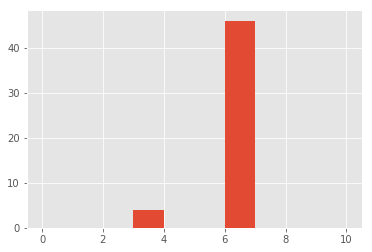

In [100]:
plt.hist((preds[:, test_ind]),bins=range(11))

In [101]:
entropies1 = []
def predictive_entropy(prob):
        return -1 * np.sum(np.log(prob) * prob, axis=0)
for x in tqdm(range(10000)):
    p, _ = np.histogram(preds[:,x], bins=range(10), normed=True)
    entropies1.append(predictive_entropy(p[p != 0]))

100%|██████████| 10000/10000 [00:00<00:00, 14605.17it/s]


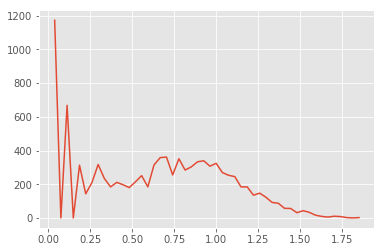

6203.80041839


In [102]:
n=len(y_test)
p, x = np.histogram(entropies1, bins=50)
plt.plot(x[1:], p)
plt.show()
print (np.sum(entropies1))